In [75]:

try:
  from ajax import Prior, Likelihood, Variational, ADVI
except:
  %pip install -qq git+https://github.com/patel-zeel/ajax.git
  from ajax import Prior, Likelihood, Variational, ADVI

try:
  import optax
except:
  %pip install -qq optax
  import optax

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import fill_params
import jax
import matplotlib.pyplot as plt
import pickle
tfd = tfp.distributions
tfb = tfp.bijectors

In [76]:
with open("../data/coin_toss",'rb') as f:
    data = pickle.load(f)
data

{'samples': array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32),
 'prior': {'alpha': 10, 'beta': 15}}

In [117]:
dataset = data['samples']
alpha_param = data['prior'] ['alpha']
beta_param = data['prior']['beta']

In [118]:
prior = Prior(
    distributions = {
        "theta" : tfd.Beta(alpha_param, beta_param)
        }
    )

In [119]:
def link_function(samples):
  probs = samples["theta"]
  return {"probs" : probs}

In [120]:
likelihood = Likelihood(tfd.Bernoulli, link_function)

In [121]:
variational = Variational(
    prior=prior,
    bijectors={"theta":tfb.Sigmoid()},
    vi_type="full_rank"
)

In [122]:
advi = ADVI(prior, likelihood, variational, dataset)

In [123]:
params = variational.get_params()

In [132]:
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss))

In [125]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params, seed = seed)
  updates, state = tx.update(grads, state)
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  return carry, loss

In [136]:
carry = {'params':params, 'state': state,'seed':jax.random.PRNGKey(10)}#key value matters keep it 10 :(
carry,loss = jax.lax.scan(update_func, carry,xs = None,length= 50) 
loss

DeviceArray([10.058517 , 16.113482 ,  6.946836 , 13.484033 ,  7.629686 ,
              7.020435 ,  6.9728394,  8.745752 ,  8.365892 ,  7.649656 ,
              6.921013 ,  7.7824326,  7.522306 ,  8.534044 ,  7.3587365,
              7.980905 ,  7.94416  ,  7.757548 ,  7.489363 ,  7.494821 ,
              7.1826124,  7.8288393,  7.843391 ,  7.5552077,  7.912609 ,
              7.8136673,  8.023399 ,  7.9987373,  7.661469 ,  7.0872355,
              7.9452777,  7.9428906,  7.7062073,  7.8023214,  7.841023 ,
              7.667098 ,  7.588679 ,  7.4945555,  7.921563 ,  8.338561 ,
              7.8039403,  7.715846 ,  8.002229 ,  7.9199047,  7.68227  ,
              7.628305 ,  7.7069063,  7.748238 ,  7.67186  ,  7.7961493],            dtype=float32)

In [137]:
keys = jax.random.PRNGKey(1)
variational.set_params(carry['params'])
sample = variational.sample(seed = keys, sample_shape = (19000,))

In [138]:
sample['theta']
# print(variational)

DeviceArray([0.41422155, 0.47354525, 0.50214016, ..., 0.61880934,
             0.48988017, 0.5268108 ], dtype=float32)

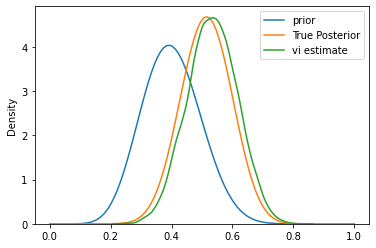

In [139]:
beta_dist_one = tfd.Beta(alpha_param, beta_param)
x = jnp.linspace(0,1,100)
plt.plot(x,beta_dist_one.prob(x),label="prior")
one= jnp.sum(dataset==1).astype('float32')
zero= jnp.sum(dataset==0).astype('float32')
beta_dist = tfd.Beta(alpha_param+one, beta_param+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label="True Posterior")
sns.kdeplot(sample['theta'],label = "vi estimate")
plt.legend()